# Map 6 - Fault
This map is from Bennison et al. (2011). It has a fault that offsets units A-C. First, we import the required libraries:

In [1]:
# Import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import geopandas as gpd
import rasterio
import gempy as gp
import gemgis as gg
from pyvistaqt import BackgroundPlotter

Then, we display the map image:

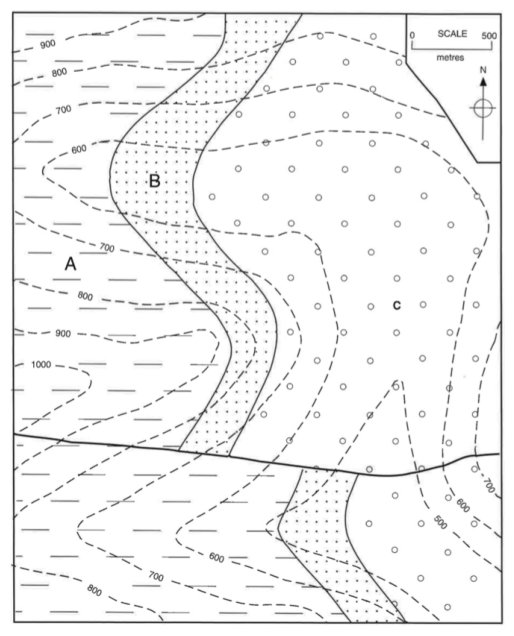

In [2]:
# Display map image
img = mpimg.imread("map6.png")
fig, ax = plt.subplots(1, figsize=(8,8))
ax.imshow(img)
ax.axis("off");

## 1. Topography

### Read and plot the contours

In [3]:
# Read the topographic contours
topo = gpd.read_file(os.path.join("contours", "contours.shp"))
topo.head()

,X,Y,Z,geometry
0,2663.93,2.48,500,POINT (2663.92600 2.47800)
1,2618.03,41.96,500,POINT (2618.02700 41.96000)
2,2566.79,93.89,500,POINT (2566.79400 93.88500)
3,2509.32,141.75,500,POINT (2509.31500 141.74800)
4,2455.20,188.54,500,POINT (2455.20500 188.53600)


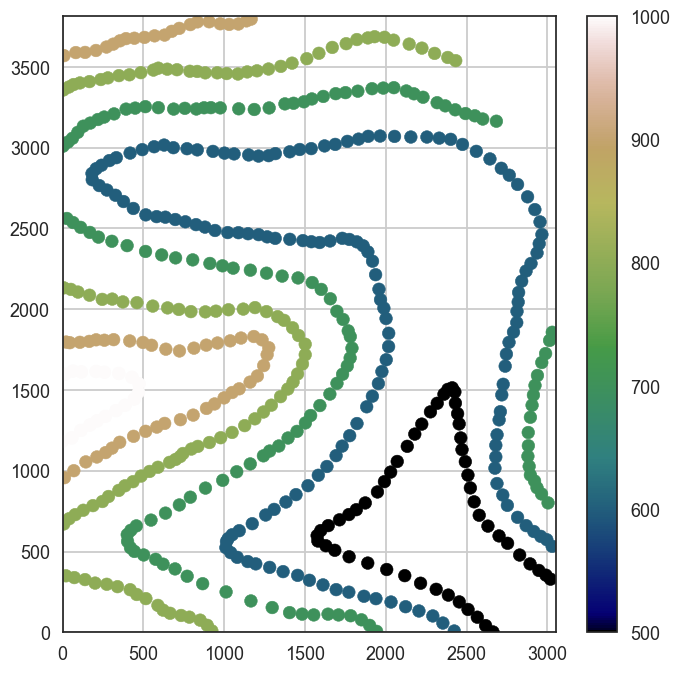

In [4]:
# Plot the contours
fig, ax = plt.subplots(1, figsize=(8, 8))
topo.plot(ax=ax, aspect="equal",column="Z", cmap="gist_earth", legend=True)
ax.set_ylim((0,3813))
ax.set_xlim((0,3051))
ax.grid();

### Interpolate the contour lines to make a digital elevation model (DEM)

In [5]:
# Interpolate contour lines to make DEM
topo_raster = gg.vector.interpolate_raster(gdf=topo,value="Z",method="rbf",res=5)

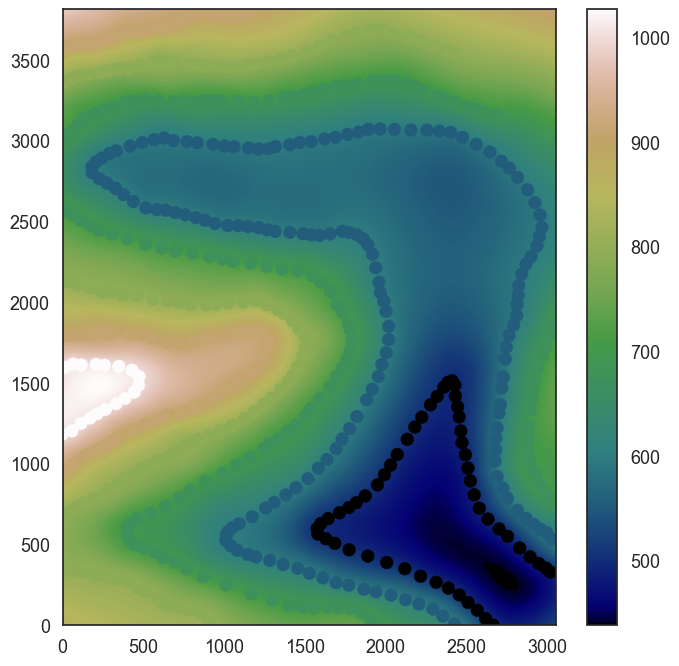

In [6]:
# Plot the DEM
fig, ax = plt.subplots(1, figsize=(8, 8))
topo.plot(ax=ax, aspect="equal", column="Z", cmap="gist_earth")
im = ax.imshow(topo_raster, origin="lower", extent=[0, 3051, 0, 3813], cmap="gist_earth")
cbar = plt.colorbar(im);

In [7]:
# Save the DEM as a tif file
gg.raster.save_as_tiff(raster=topo_raster, path="dem_map6.tif", 
                       extent=[0, 3051, 0, 3813], crs="EPSG:4326", overwrite_file=True)

Raster successfully saved


In [8]:
# Open the DEM from tif file
topo_raster = rasterio.open("dem_map6.tif")

## 2. Stratigraphic boundaries or units' contacts

In [9]:
# Read the points on the contacts. These are the bases of the units and the fault
contacts = gpd.read_file(os.path.join("contacts", "contacts.shp"))
contacts.head()

,X,Y,formation,geometry
0,1513.34,3379.21,B,POINT (1513.33800 3379.21200)
1,1153.08,2535.07,B,POINT (1153.08300 2535.06500)
2,1539.21,1453.44,B,POINT (1539.20900 1453.44400)
3,2145.55,413.20,B,POINT (2145.54600 413.20100)
4,1122.31,3414.52,A,POINT (1122.31300 3414.52100)


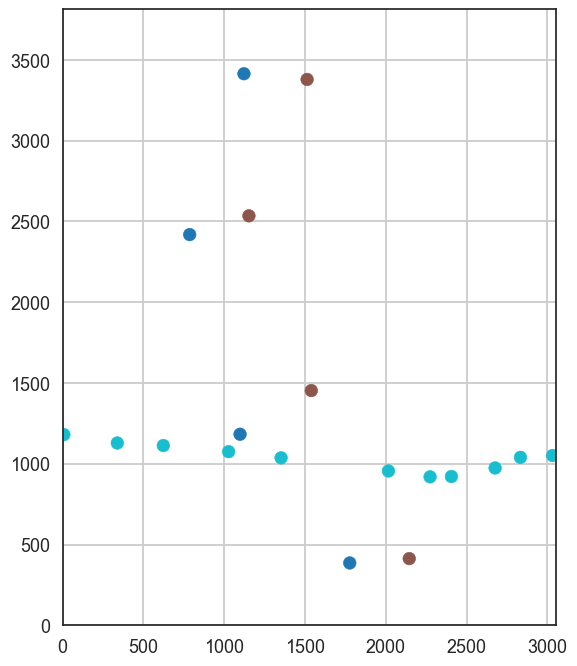

In [10]:
# Plot the points on the contacts, F stands for "fault"
fig, ax = plt.subplots(1, figsize=(8, 8))
contacts.plot(ax=ax, column="formation", aspect="equal")
ax.set_ylim((0,3813))
ax.set_xlim((0,3051))
ax.grid();

In [11]:
# Extract the Z coordinate of the points at the contacts
contacts_with_Z = gg.vector.extract_xyz(gdf=contacts, dem=topo_raster)
contacts_with_Z.head()

,X,Y,formation,geometry,Z
0,1513.34,3379.21,B,POINT (1513.33800 3379.21200),726.96
1,1153.08,2535.07,B,POINT (1153.08300 2535.06500),587.61
2,1539.21,1453.44,B,POINT (1539.20900 1453.44400),733.58
3,2145.55,413.20,B,POINT (2145.54600 413.20100),477.88
4,1122.31,3414.52,A,POINT (1122.31300 3414.52100),775.95


### Strike lines

In [12]:
# Read the strike lines on both base B and the fault
gdf = gpd.read_file(os.path.join("strike_lines", "strike_lines.shp"))
gdf.head()

,X,Y,Z,formation,id,geometry
0,1201.37,2464.15,600,B,1,POINT (1201.36700 2464.15400)
1,1180.32,2952.93,600,B,1,POINT (1180.32000 2952.92900)
2,1423.78,2193.59,700,B,2,POINT (1423.77900 2193.59400)
3,1429.73,3273.28,700,B,2,POINT (1429.73300 3273.28400)
4,2007.41,953.37,500,F,3,POINT (2007.41200 953.37300)


In [13]:
# Convert the points into strike lines
linestring_gdf_B = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "B"])
linestring_gdf_F = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "F"])

In [14]:
# Check that the strike lines are valid
linestring_gdf_B.is_valid

0    True
1    True
dtype: bool

In [15]:
linestring_gdf_F.is_valid

0    True
1    True
2    True
dtype: bool

In [16]:
#Calculate orientations of base B
orientations_B = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_B)
orientations_B.head()

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,24.07,269.84,650.00,POINT (1308.79975 2720.99025),1.00,1308.80,2720.99,B


In [17]:
# Calculate orientations of fault
orientations_F = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_F)
orientations_F.head()

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,68.92,181.10,550.00,POINT (2201.03550 967.37950),1.00,2201.04,967.38,F
1,59.91,180.55,650.00,POINT (2088.04500 1021.55075),1.00,2088.05,1021.55,F


Base B and in fact A-C dip 24 degrees to the west. The fault dips 60-70 degrees to the south. The fault puts in contact older units (e.g. B) in the footwall, against younger units (e.g. C) in the hanging wall. Therefore, the downthrown block is the southern block (hanging wall), and this is a normal fault.

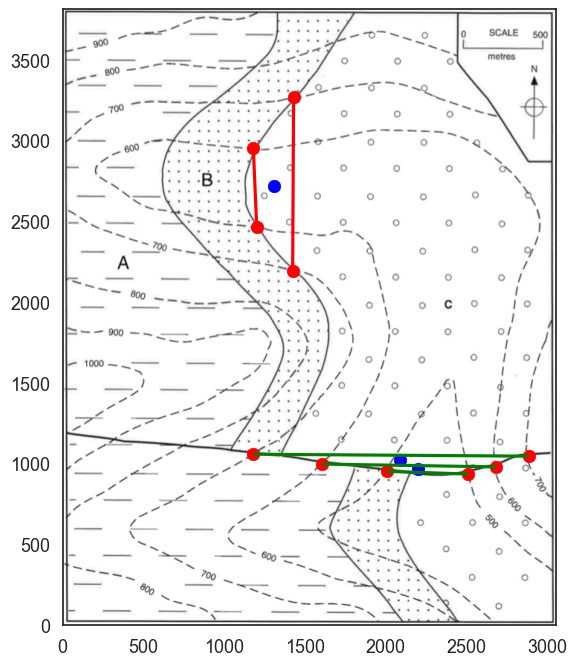

In [18]:
# Plot all this information on the map, so we can better understand this structure
fig, ax = plt.subplots(1,1,figsize=(8, 8))
ax.imshow(img, extent=[0, 3051, 0, 3813], cmap="gray")
# plot points
gdf.plot(ax=ax, aspect="equal", color="red")
# plot strike lines
# base B
linestring_gdf_B.plot(ax=ax, aspect="equal", color="red") 
orientations_B.plot(ax=ax, aspect="equal", color="blue")
# fault
linestring_gdf_F.plot(ax=ax, aspect="equal", color="green") 
orientations_F.plot(ax=ax, aspect="equal", color="blue");

In [19]:
# Merge orientations
orientations = pd.concat([orientations_B, orientations_F]).reset_index()
orientations.head()

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,24.07,269.84,650.00,POINT (1308.79975 2720.99025),1.00,1308.80,2720.99,B
1,0,68.92,181.10,550.00,POINT (2201.03550 967.37950),1.00,2201.04,967.38,F
2,1,59.91,180.55,650.00,POINT (2088.04500 1021.55075),1.00,2088.05,1021.55,F


## 3. Construction of the model in GemPy

In [20]:
# Create a geomodel object called model6
geo_model = gp.create_model("model6")

In [21]:
# Define model extent, resolution, surface points, and orientations
gp.init_data(geo_model, [0, 3051, 0, 3813, 0, 1000], [100, 100, 100],
             surface_points_df=contacts_with_Z,
             orientations_df=orientations, default_values=True);

Active grids: ['regular']


In [22]:
# Check default series
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,B,Default series,1,#015482,1
1,A,Default series,2,#9f0052,2
2,F,Default series,3,#ffbe00,3


In [23]:
# The base of the lowermost unit C does not outcrop in the map
# This unit is our "basement", we add it manually
geo_model.add_surfaces("C")

# The surfaces are divided into 2 series
# Strata = units A-C, Fault = the fault
gp.map_stack_to_surfaces(geo_model,{"Fault": ("F"),"Strata": ("A","B", "C"),},
                         remove_unused_series=True)

# Tell GemPy that the series Fault is a fault
geo_model.set_is_fault(["Fault"])

Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.


,order_series,BottomRelation,isActive,isFault,isFinite
Fault,1,Fault,True,True,False
Strata,2,Erosion,True,False,False


In [24]:
# Check that the data are correct
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id,No. of Interfaces,No. of Orientations
2,F,Fault,1,False,True,True,True,#527682,NaN,NaN,NaN,1,11,2
0,B,Strata,1,False,False,True,True,#015482,NaN,NaN,NaN,2,4,1
1,A,Strata,2,False,False,True,True,#9f0052,NaN,NaN,NaN,3,4,0
3,C,Strata,3,True,False,True,True,#728f02,NaN,NaN,NaN,4,0,0


In [25]:
# Set the topography of the model
geo_model.set_topography(source="gdal",filepath="dem_map6.tif");

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


In [26]:
# Plot the points on the contacts and topography in 3D 
# This will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type="background",show_topography=True);

In [27]:
# Now we have enough data to interpolate. This may take some time, please wait
gp.set_interpolator(geo_model, compile_theano=True, 
                    theano_optimizer="fast_compile");

Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                    values
range             4984.73
$C_o$           591608.81
drift equations    [3, 3]


In [28]:
# Compute the geological model. This may take some time, please wait
gp.compute_model(geo_model);

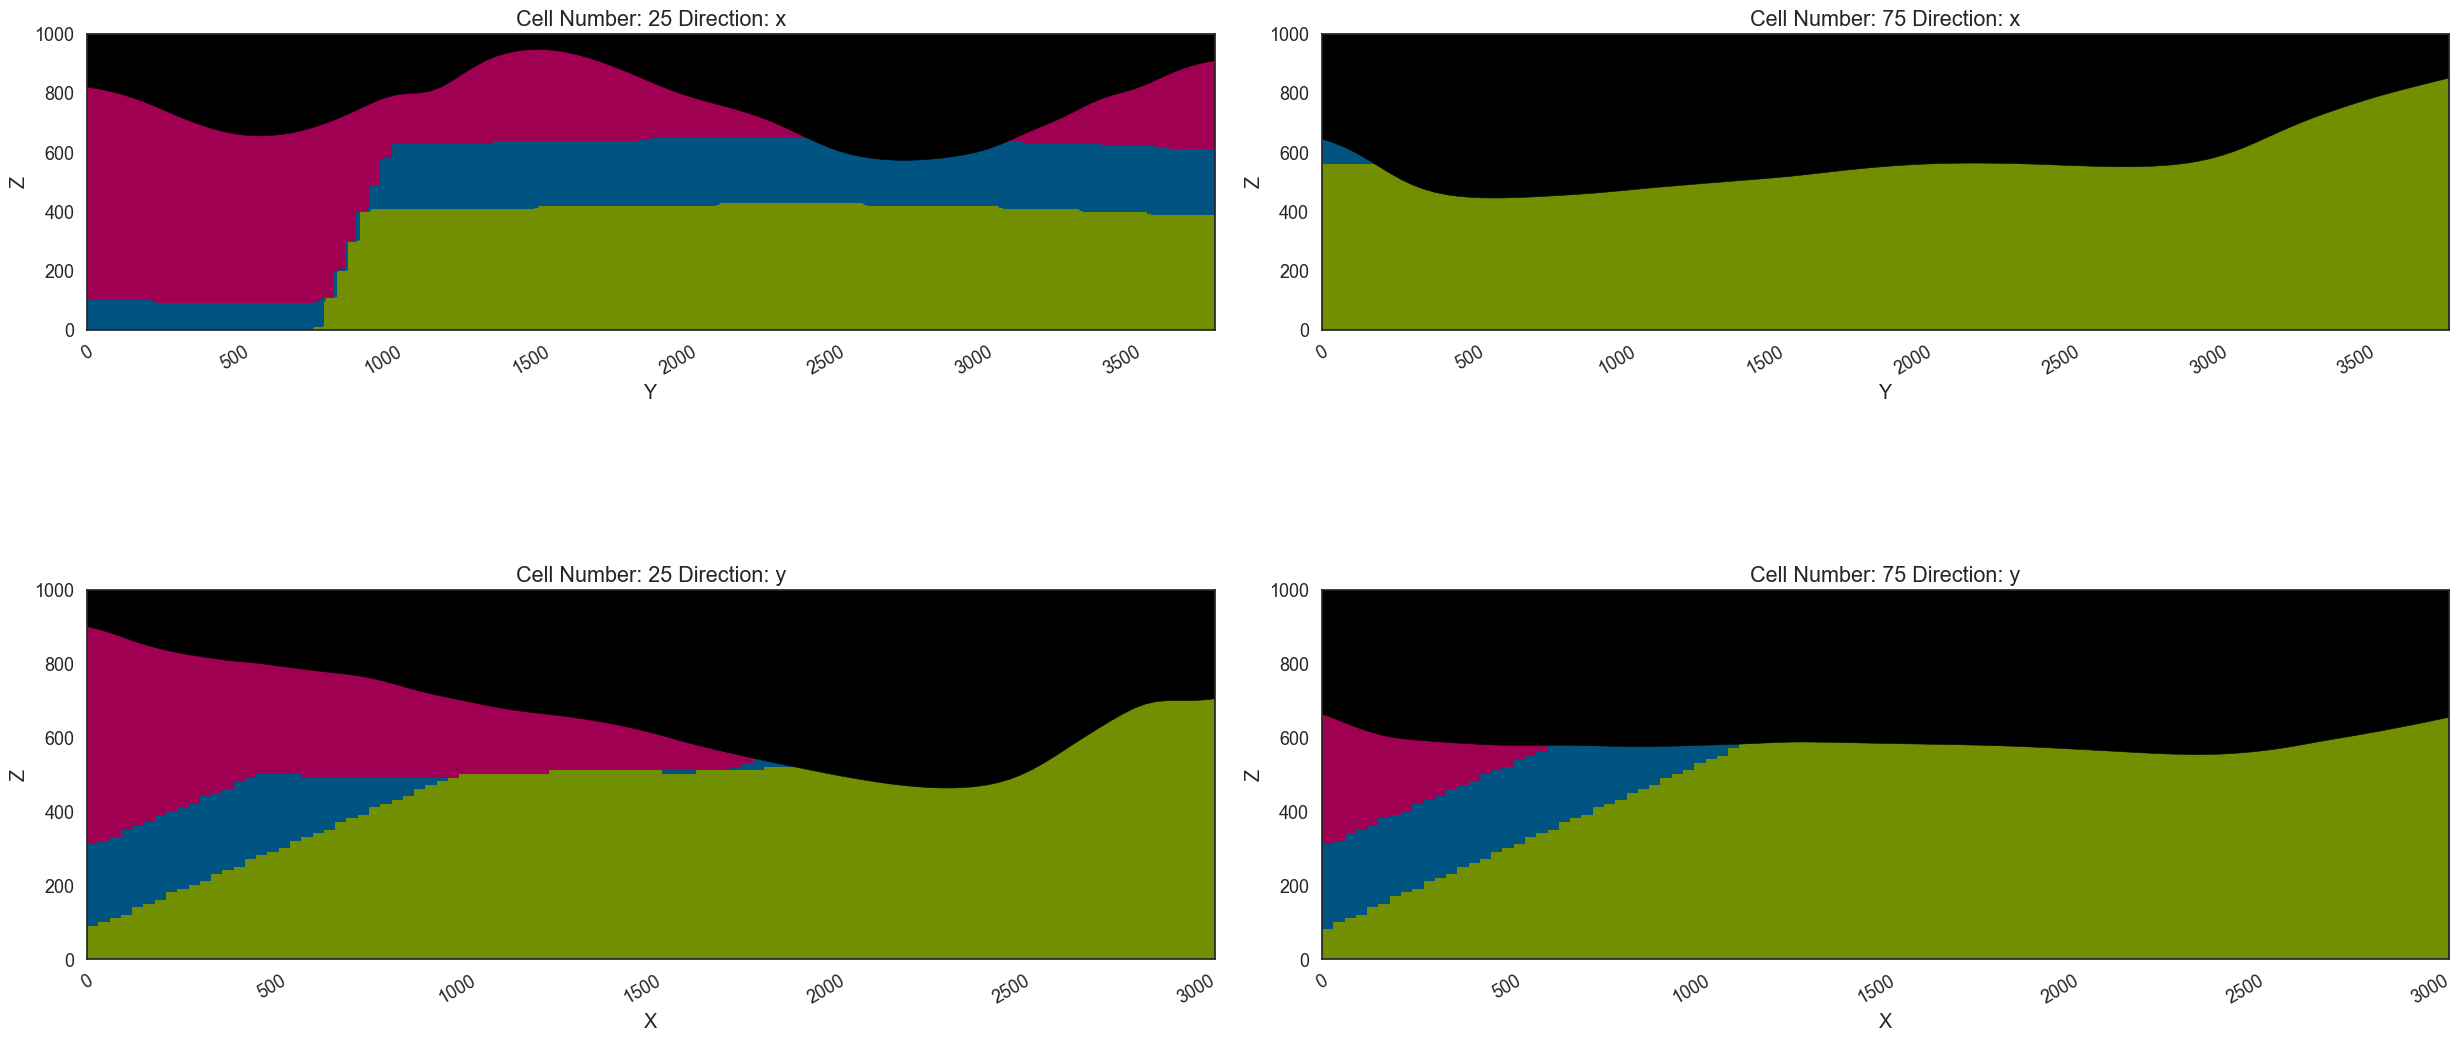

In [29]:
# Plot north-south and east-west sections without vertical exaggeration
gp.plot_2d(geo_model, direction=["x", "x", "y", "y"], cell_number=[25, 75, 25, 75], 
           show_data=False, show_boundaries=False, show_topography=True, show=False);

In [30]:
# Plot the geomodel in 3D, this will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type="background", show_topography=True, show_lith=False);